In [1]:
using Markdown

In [2]:
using Plots, LaTeXStrings, QuadGK, Roots, DifferentialEquations

# 1D Bistable Example

_Define separate production and degradation terms_

In [3]:
begin
	n_max = 200.
	n_min = 1 # need to avoid 0 for log we'll evaluate later
	n = n_min:0.1:n_max
	γ = 1
	ks = 1e-4
	ν0 = 12.5
	ν1 = 200
	production(n) = (ν0+ ν1 * ks*n^2)/(1+ks*n^2)
	degradation(n) = γ*n
end

degradation (generic function with 1 method)

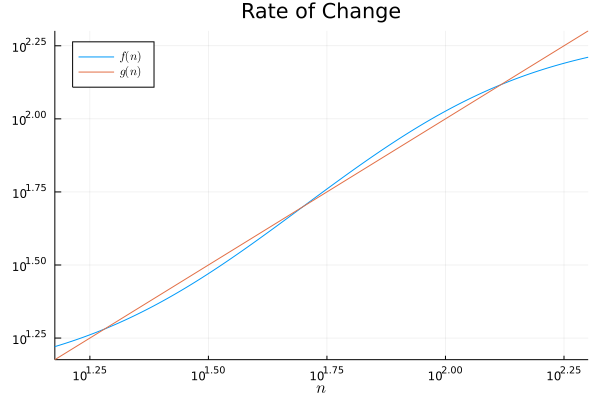

In [4]:
begin
	
	plot(production, n, label=L"f(n)")
	p1 = plot!(degradation, n, label=L"g(n)", xlabel=L"n", title="Rate of Change", scale=:log10, xlimits=(15, n_max), ylimits=(15, 200), legend=:topleft)
# plot!(n->production(n)  - degradation(n), n, label=L"\frac{dn}{dt}", 
# 		ylims=(-20, 150), xlims=(0, 150), legend=:topleft, title="Time evolution")
end

_Compute the fixed points to split up the 2 attractors into **Basins of Attractions**_"

In [5]:
fixed_points = find_zeros(n-> production(n) - degradation(n), n_min, n_max)

3-element Vector{Float64}:
  19.098300562505266
  50.000000000000014
 130.90169943749478

_Integrate to get the quasi-potential_

In [6]:
begin
	f = production
	g = degradation
	
	ϕ(n) = quadgk(n -> -2*(f(n) -g(n))/(f(n) + g(n)), n_min, n)[1]
end

ϕ (generic function with 1 method)

In [7]:
ϕ_vec = ϕ.(n)

1991-element Vector{Float64}:
 -0.0
 -0.16905266634092922
 -0.33541586771004656
 -0.49913123834477463
 -0.660239686628211
 -0.818781410188954
 -0.9747959106256152
 -1.1283220078669904
 -1.2793978541784838
 -1.4280609478250232
 -1.574348146400372
 -1.7182956798324023
 -1.8599391630735853
  ⋮
 -4.858877155199968
 -4.838515233267167
 -4.818122088274848
 -4.797697722363832
 -4.777242137690655
 -4.756755336427483
 -4.736237320762113
 -4.715688092897896
 -4.695107655053741
 -4.674496009463997
 -4.653853158378498
 -4.633179104062437

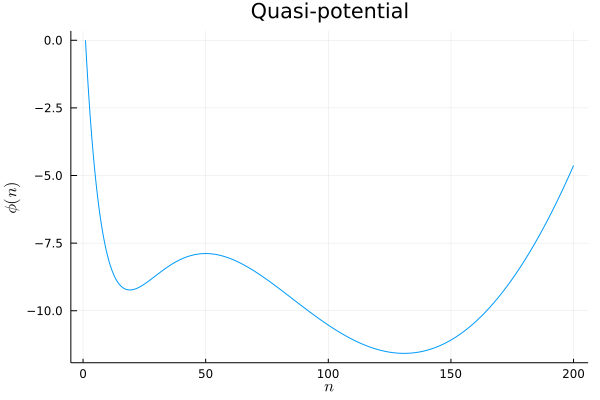

In [8]:
p2 = plot(n, ϕ_vec, ylabel=L"\phi(n)", xlabel=L"n", label="", title="Quasi-potential")

_Show the the probability due to the quasi-potential dominates compared to the other term in the equation_

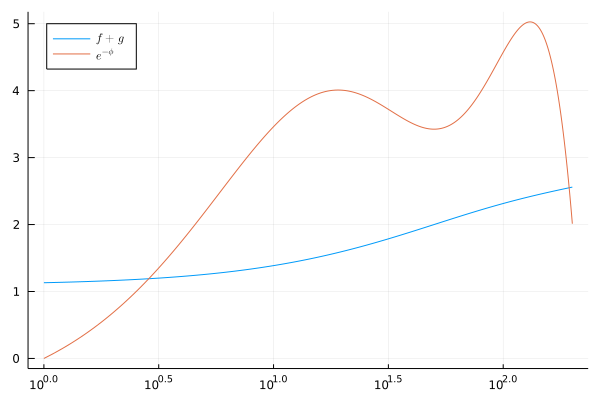

In [9]:
begin
	plot(n->log10.(f(n) + g(n)), n, label=L"f + g")
	plot!(n, log10.(ℯ.^(-ϕ_vec)), label=L"e^{-\phi}")
	p3 = plot!(xaxis=:log10, legend=:topleft)
end

_Compute the normalized probability_

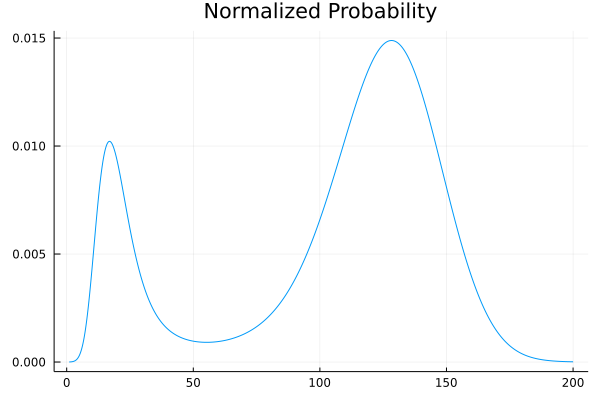

In [10]:
begin
	fn = f.(n)
	gn = g.(n)
	p_unnormal(n) =  ℯ^(-ϕ(n)) / (f(n)+g(n))
	norm = quadgk(p_unnormal, n_min, n_max)[1]
	p_normal(n) = 1/norm * p_unnormal(n)
	p4 = plot(p_normal,n,  title = "Normalized Probability", label="")
end

_Set up the jump process simulation_

In [11]:
random_count() = floor(Int, n_min + rand() * n_max)

random_count (generic function with 1 method)

In [12]:
begin
	affect1!(integrator) = integrator.u += 1
	affect2!(integrator) = integrator.u -= 1
	prodJump = ConstantRateJump((u, p, t) -> f(u), affect1!)
	degJump = ConstantRateJump((u, p, t) -> g(u), affect2!)
	u0 = random_count()
	t = (0.0, 5000.0)
	dprob = DiscreteProblem(u0, t)
	jprob = JumpProblem(dprob, Direct(), prodJump, degJump)
end


Number of constant rate jumps: 2
Number of variable rate jumps: 0


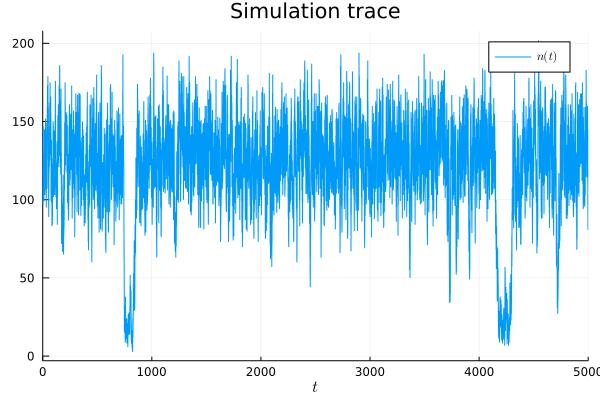

In [13]:
begin
	sim_res = solve(jprob, SSAStepper())
	p5 = plot(sim_res, xlabel=L"t", label=L"n(t)", title="Simulation trace")
end

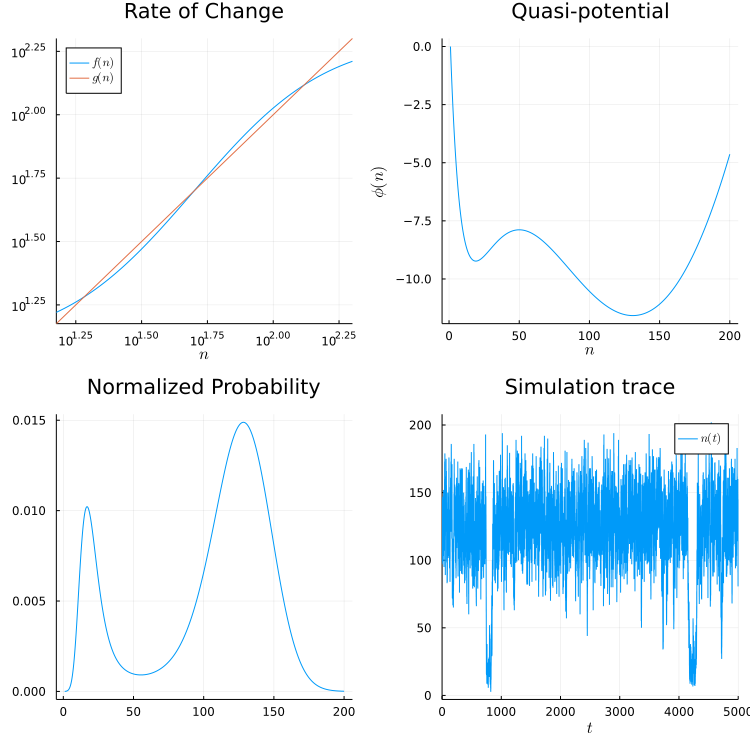

In [14]:
begin
	pf = plot(p1, p2, p4, p5, layout = grid(2,2), size=(750, 750))
	# savefig(pf, "ch3_bistable_prob.pdf")
	pf
end

_Setup functions to do a longer time simulation and compare to integrated probability distribution_

In [15]:
function calculate_time_fraction(sim_result, split)
	dts = diff(sim_result.t)
	dt_vals = collect(zip(dts, map(last, sim_result.u[1:end])))
	high = sum(map(first, filter(dtu -> last(dtu) > split, dt_vals)))
	low = sum(map(first, filter(dtu -> last(dtu) < split, dt_vals)))
	high, low
end

calculate_time_fraction (generic function with 1 method)

In [16]:
function big_sim(num_sim = 25)
	function prob_func(prob, i, repeat)
        remake(prob, u0=random_count())
    end
	num_steps = 0
    ensemble_prob = EnsembleProblem(jprob, prob_func=prob_func)
	sim = solve(ensemble_prob, SSAStepper(), trajectories=num_sim)
	totals = [0., 0.]
	for j in 1:num_sim
		totals.+= calculate_time_fraction(sim[j], fixed_points[2])
		num_steps += length(sim[j])
	end
	totals, num_steps
end

big_sim (generic function with 2 methods)

In [17]:
totals, num_steps = big_sim()

([115699.83688188824, 9300.163118111735], 29192028)

In [18]:
begin
	sim_frac = totals./sum(totals)
end

2-element Vector{Float64}:
 0.9255986950551061
 0.07440130494489389

Time fractions from simulations is $(sim_frac)

In [19]:
begin
	p_low = quadgk(p_normal, n_min, fixed_points[2])[1]
	p_high = quadgk(p_normal, fixed_points[2], n_max)[1]
	comp_frac = p_high, p_low
end

(0.8055671593777174, 0.19443284062228242)

Time fractions from integration of probability is $(comp_frac)